# Prepare SpaceNet 7 Data for Model Training

We assume that initial steps of README have been executed and that this notebook is running in a docker container.  See the `src` directory for functions used in the algorithm.  

In [1]:
# Dataset location (edit as needed)
root_dir = '../../'

In [2]:
import sys
print(sys.version)
!python --version

3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
Python 3.7.8


In [3]:
from platform import python_version
print(python_version())

3.7.8


In [4]:
import multiprocessing
import pandas as pd
import numpy as np
import skimage
import gdal
import sys
import os

import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
mpl.rcParams['figure.dpi'] = 300

import solaris as sol
from solaris.raster.image import create_multiband_geotiff
from solaris.utils.core import _check_gdf_load

# import from data_prep_funcs
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from sn7_baseline_prep_funcs import map_wrapper, make_geojsons_and_masks

/data1/home/hoyin/anaconda3-1/envs/bear_solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data1/home/hoyin/anaconda3-1/envs/bear_solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data1/home/hoyin/anaconda3-1/envs/bear_solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data1/

In [5]:
# Create Training Masks
# Multi-thread to increase speed
# We'll only make a 1-channel mask for now, but Solaris supports a multi-channel mask as well, see
#     https://github.com/CosmiQ/solaris/blob/master/docs/tutorials/notebooks/api_masks_tutorial.ipynb

aois = sorted([f for f in os.listdir(os.path.join(root_dir, 'train'))
               if os.path.isdir(os.path.join(root_dir, 'train', f))])
n_threads = 10
params = [] 
make_fbc = False

input_args = []
for i, aoi in enumerate(aois):
    print(i, "aoi:", aoi)
    im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked/')
    json_dir = os.path.join(root_dir, 'train', aoi, 'labels_match/')
    out_dir_mask = os.path.join(root_dir, 'train', aoi, 'masks/')
    out_dir_mask_fbc = os.path.join(root_dir, 'train', aoi, 'masks_fbc/')
    os.makedirs(out_dir_mask, exist_ok=True)
    if make_fbc:
        os.makedirs(out_dir_mask_fbc, exist_ok=True)

    json_files = sorted([f
                for f in os.listdir(os.path.join(json_dir))
                if f.endswith('Buildings.geojson') and os.path.exists(os.path.join(json_dir, f))])
    for j, f in enumerate(json_files):
        # print(i, j, f)
        name_root = f.split('.')[0]
        json_path = os.path.join(json_dir, f)
        image_path = os.path.join(im_dir, name_root + '.tif').replace('labels', 'images').replace('_Buildings', '')
        output_path_mask = os.path.join(out_dir_mask, name_root + '.tif')
        if make_fbc:
            output_path_mask_fbc = os.path.join(out_dir_mask_fbc, name_root + '.tif')
        else:
            output_path_mask_fbc = None
            
        if (os.path.exists(output_path_mask)):
             continue
        else: 
            input_args.append([make_geojsons_and_masks, 
                               name_root, image_path, json_path,
                               output_path_mask, output_path_mask_fbc])

# execute 
print("len input_args", len(input_args))
print("Execute...\n")
with multiprocessing.Pool(n_threads) as pool:
    pool.map(map_wrapper, input_args)


0 aoi: L15-0331E-1257N_1327_3160_13
1 aoi: L15-0357E-1223N_1429_3296_13
2 aoi: L15-0358E-1220N_1433_3310_13
3 aoi: L15-0361E-1300N_1446_2989_13
4 aoi: L15-0368E-1245N_1474_3210_13
5 aoi: L15-0387E-1276N_1549_3087_13
6 aoi: L15-0434E-1218N_1736_3318_13
7 aoi: L15-0457E-1135N_1831_3648_13
8 aoi: L15-0487E-1246N_1950_3207_13
9 aoi: L15-0506E-1204N_2027_3374_13
10 aoi: L15-0544E-1228N_2176_3279_13
11 aoi: L15-0566E-1185N_2265_3451_13
12 aoi: L15-0571E-1075N_2287_3888_13
13 aoi: L15-0577E-1243N_2309_3217_13
14 aoi: L15-0586E-1127N_2345_3680_13
15 aoi: L15-0595E-1278N_2383_3079_13
16 aoi: L15-0614E-0946N_2459_4406_13
17 aoi: L15-0632E-0892N_2528_4620_13
18 aoi: L15-0683E-1006N_2732_4164_13
19 aoi: L15-0760E-0887N_3041_4643_13
20 aoi: L15-0924E-1108N_3699_3757_13
21 aoi: L15-0977E-1187N_3911_3441_13
22 aoi: L15-1014E-1375N_4056_2688_13
23 aoi: L15-1015E-1062N_4061_3941_13
24 aoi: L15-1025E-1366N_4102_2726_13
25 aoi: L15-1049E-1370N_4196_2710_13
26 aoi: L15-1138E-1216N_4553_3325_13
27 aoi: L15

  name_root: global_monthly_2018_05_mosaic_L15-1204E-1202N_4816_3380_13_BuildingsError loading image ../../train/L15-1203E-1203N_4815_3378_13/images_masked/global_monthly_2018_06_mosaic_L15-1203E-1203N_4815_3378_13.tif, skipping...

Error loading image ../../train/L15-1204E-1202N_4816_3380_13/images_masked/global_monthly_2019_01_mosaic_L15-1204E-1202N_4816_3380_13.tif, skipping...  name_root:
 global_monthly_2018_07_mosaic_L15-1203E-1203N_4815_3378_13_Buildings
Error loading image ../../train/L15-1204E-1202N_4816_3380_13/images_masked/global_monthly_2017_11_mosaic_L15-1204E-1202N_4816_3380_13.tif, skipping...
  name_root:  name_root:  global_monthly_2019_02_mosaic_L15-1204E-1202N_4816_3380_13_Buildingsglobal_monthly_2018_01_mosaic_L15-1204E-1202N_4816_3380_13_Buildings

Error loading image ../../train/L15-1203E-1203N_4815_3378_13/images_masked/global_monthly_2019_07_mosaic_L15-1203E-1203N_4815_3378_13.tif, skipping...Error loading image ../../train/L15-1203E-1203N_4815_3378_13/images_m

  name_root: global_monthly_2019_06_mosaic_L15-1615E-1205N_6460_3370_13_Buildings
Error loading image ../../train/L15-1615E-1205N_6460_3370_13/images_masked/global_monthly_2018_04_mosaic_L15-1615E-1205N_6460_3370_13.tif, skipping...
  name_root: global_monthly_2018_05_mosaic_L15-1615E-1205N_6460_3370_13_Buildings
Error loading image ../../train/L15-1615E-1206N_6460_3366_13/images_masked/global_monthly_2017_07_mosaic_L15-1615E-1206N_6460_3366_13.tif, skipping...
Error loading image ../../train/L15-1615E-1206N_6460_3366_13/images_masked/global_monthly_2018_07_mosaic_L15-1615E-1206N_6460_3366_13.tif, skipping...Error loading image ../../train/L15-1615E-1206N_6460_3366_13/images_masked/global_monthly_2019_02_mosaic_L15-1615E-1206N_6460_3366_13.tif, skipping...Error loading image ../../train/L15-1615E-1206N_6460_3366_13/images_masked/global_monthly_2018_02_mosaic_L15-1615E-1206N_6460_3366_13.tif, skipping...


  name_root: global_monthly_2017_08_mosaic_L15-1615E-1206N_6460_3366_13_Buildings

Error loading image ../../train/L15-1669E-1160N_6678_3548_13/images_masked/global_monthly_2019_09_mosaic_L15-1669E-1160N_6678_3548_13.tif, skipping...
  name_root: global_monthly_2018_11_mosaic_L15-1669E-1160N_6678_3548_13_Buildings
  name_root: Error loading image ../../train/L15-1615E-1206N_6460_3366_13/images_masked/global_monthly_2018_05_mosaic_L15-1615E-1206N_6460_3366_13.tif, skipping...Error loading image ../../train/L15-1615E-1206N_6460_3366_13/images_masked/global_monthly_2017_11_mosaic_L15-1615E-1206N_6460_3366_13.tif, skipping...global_monthly_2017_08_mosaic_L15-1669E-1160N_6679_3549_13_Buildings


  name_root: global_monthly_2018_01_mosaic_L15-1615E-1206N_6460_3366_13_Buildings
  name_root: global_monthly_2018_06_mosaic_L15-1615E-1206N_6460_3366_13_Buildings
Error loading image ../../train/L15-1615E-1206N_6460_3366_13/images_masked/global_monthly_2018_12_mosaic_L15-1615E-1206N_6460_3366_13.tif, skipping...
  name_root: global_monthly_2019_01_mosaic_L15-1615E-1206N_6460_3366

  name_root: global_monthly_2019_01_mosaic_L15-1690E-1211N_6763_3346_13_BuildingsError loading image ../../train/L15-1669E-1160N_6679_3549_13/images_masked/global_monthly_2017_09_mosaic_L15-1669E-1160N_6679_3549_13.tif, skipping...

Error loading image ../../train/L15-1690E-1211N_6763_3346_13/images_masked/global_monthly_2018_05_mosaic_L15-1690E-1211N_6763_3346_13.tif, skipping...
Error loading image ../../train/L15-1691E-1211N_6764_3347_13/images_masked/global_monthly_2017_07_mosaic_L15-1691E-1211N_6764_3347_13.tif, skipping...
  name_root: global_monthly_2018_06_mosaic_L15-1690E-1211N_6763_3346_13_Buildings
  name_root:  name_root: global_monthly_2017_10_mosaic_L15-1669E-1160N_6679_3549_13_Buildings 
global_monthly_2017_08_mosaic_L15-1691E-1211N_6764_3347_13_Buildings
Error loading image ../../train/L15-1690E-1211N_6763_3346_13/images_masked/global_monthly_2017_11_mosaic_L15-1690E-1211N_6763_3346_13.tif, skipping...
  name_root: global_monthly_2018_01_mosaic_L15-1690E-1211N_6763_3346

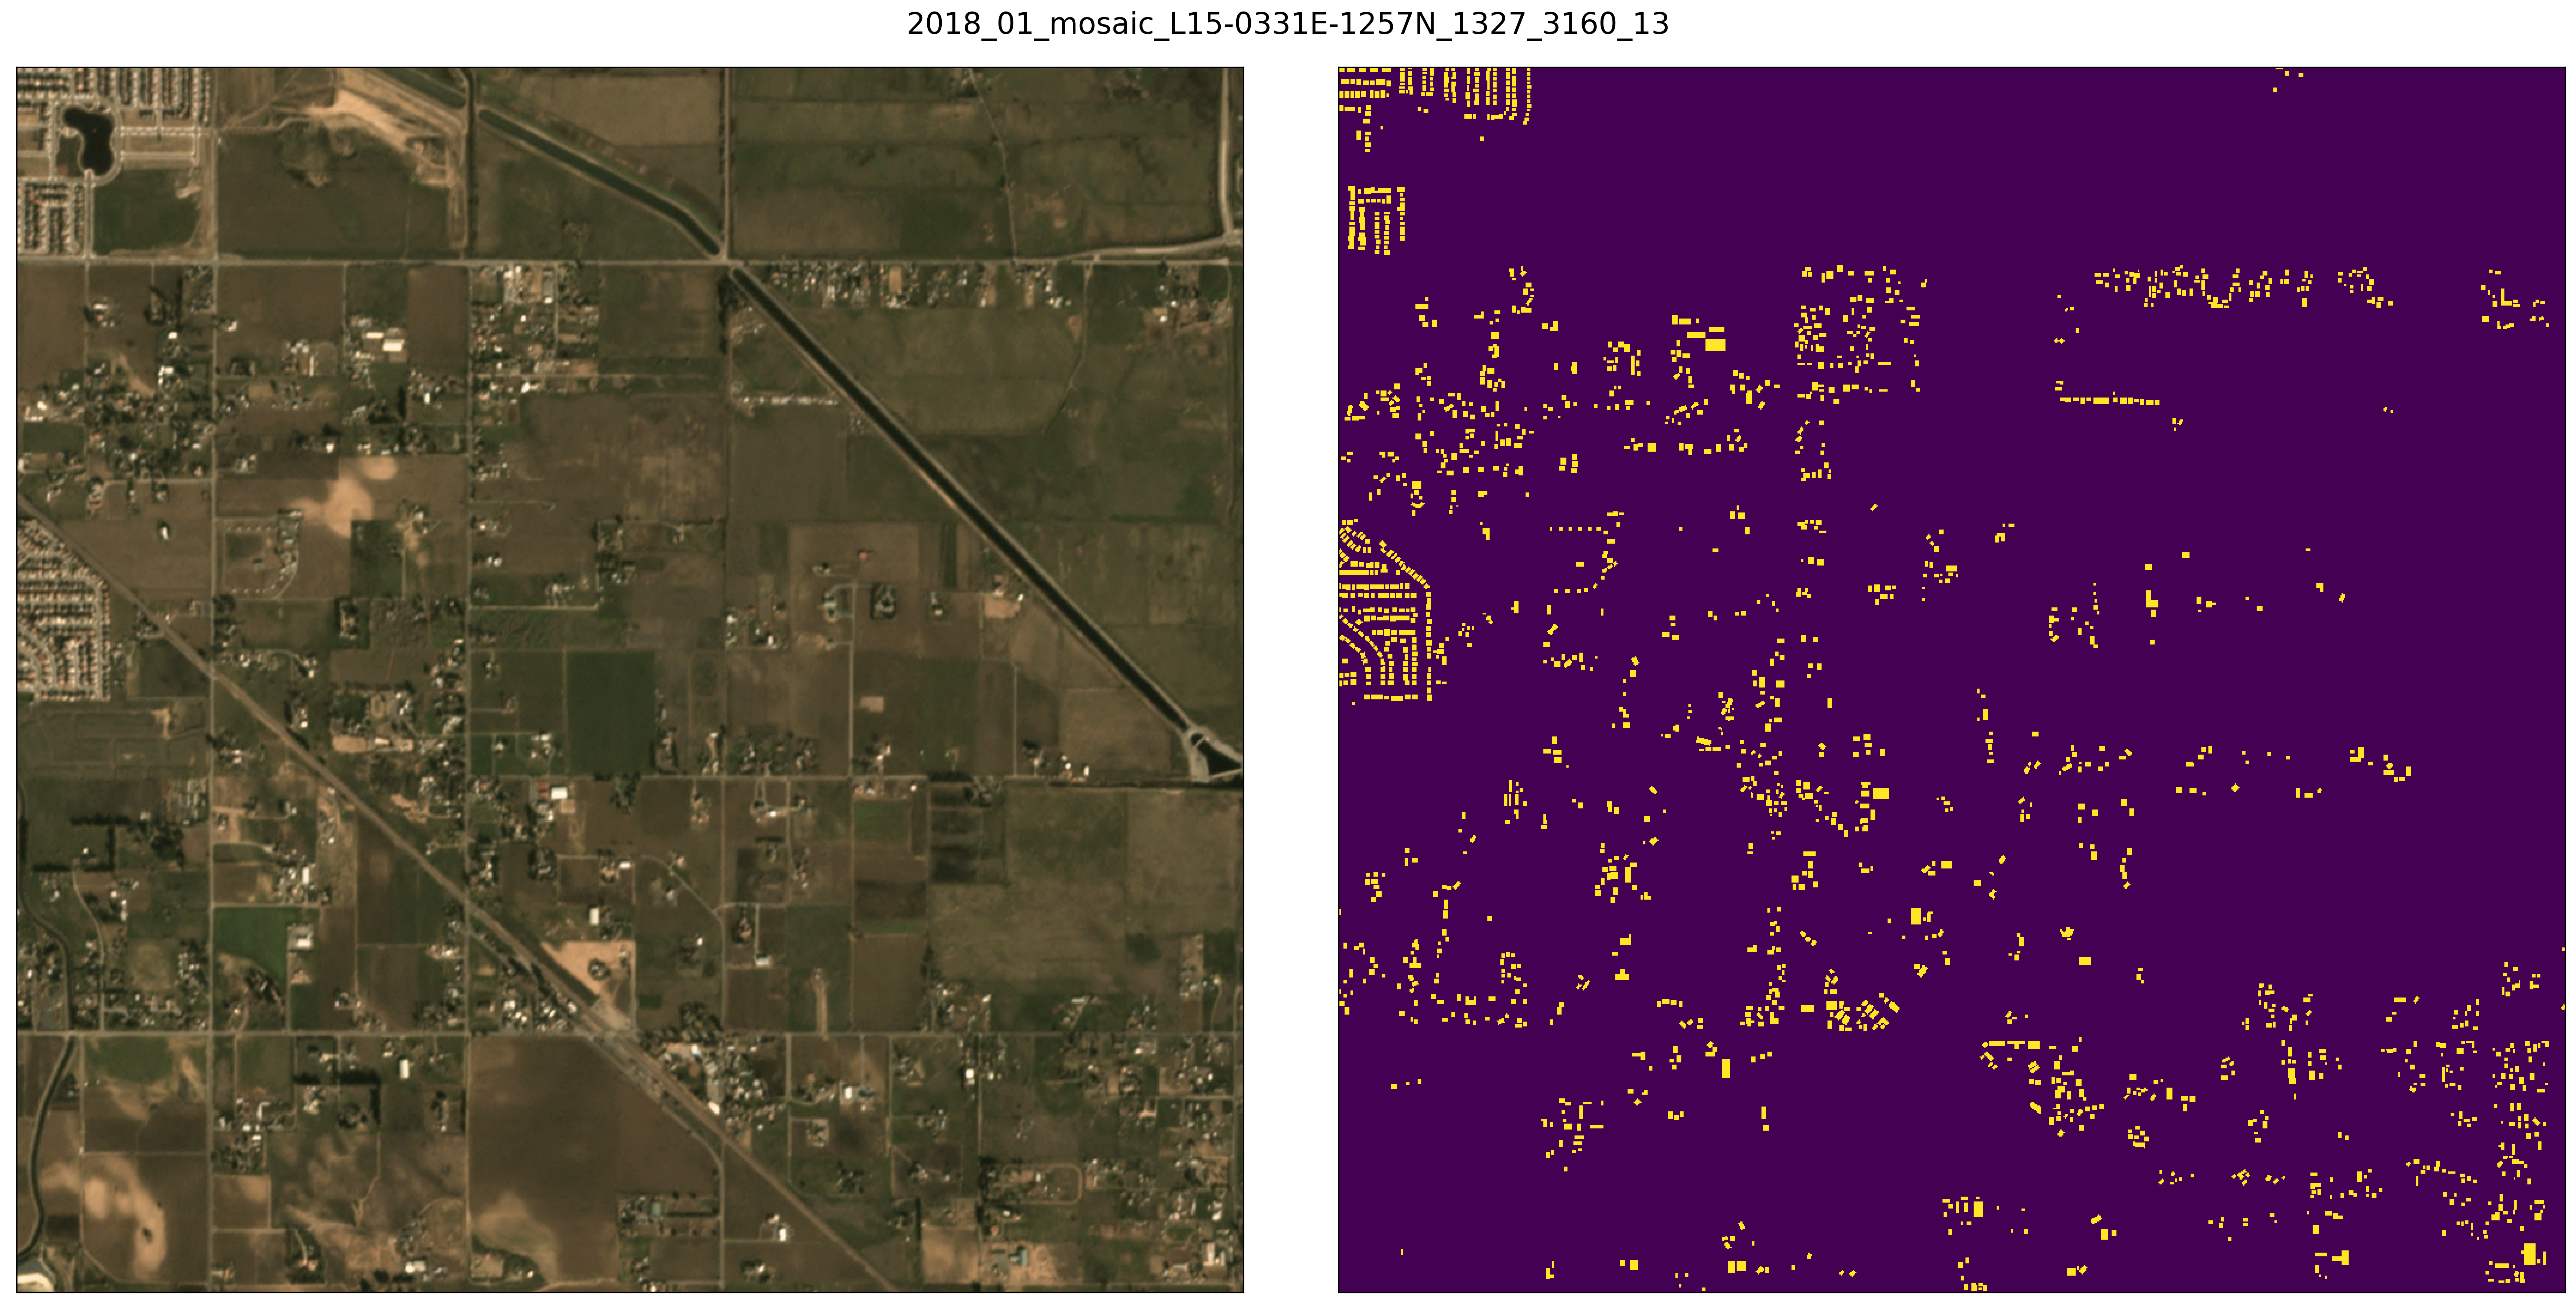

In [6]:
# Inspect visually

aoi = 'L15-0331E-1257N_1327_3160_13'
im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked')
mask_dir = os.path.join(root_dir, 'train', aoi, 'masks')

im_list = sorted([z for z in os.listdir(im_dir) if z.endswith('.tif')])
im_file = im_list[0]

im_path = os.path.join(im_dir, im_file)
mask_path = os.path.join(mask_dir, im_file.split('.')[0] + '_Buildings.tif')
im = skimage.io.imread(im_path)
mask = skimage.io.imread(mask_path)

figsize=(24, 12)
name = im_file.split('.')[0].split('global_monthly_')[-1]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(im)
ax0.set_xticks([])
ax0.set_yticks([])
# _ = ax0.set_title(name)
_ = ax1.imshow(mask)
ax1.set_xticks([])
ax1.set_yticks([])
# _ = ax1.set_title(name)
_ = fig.suptitle(name)
plt.tight_layout()

name_root: global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings


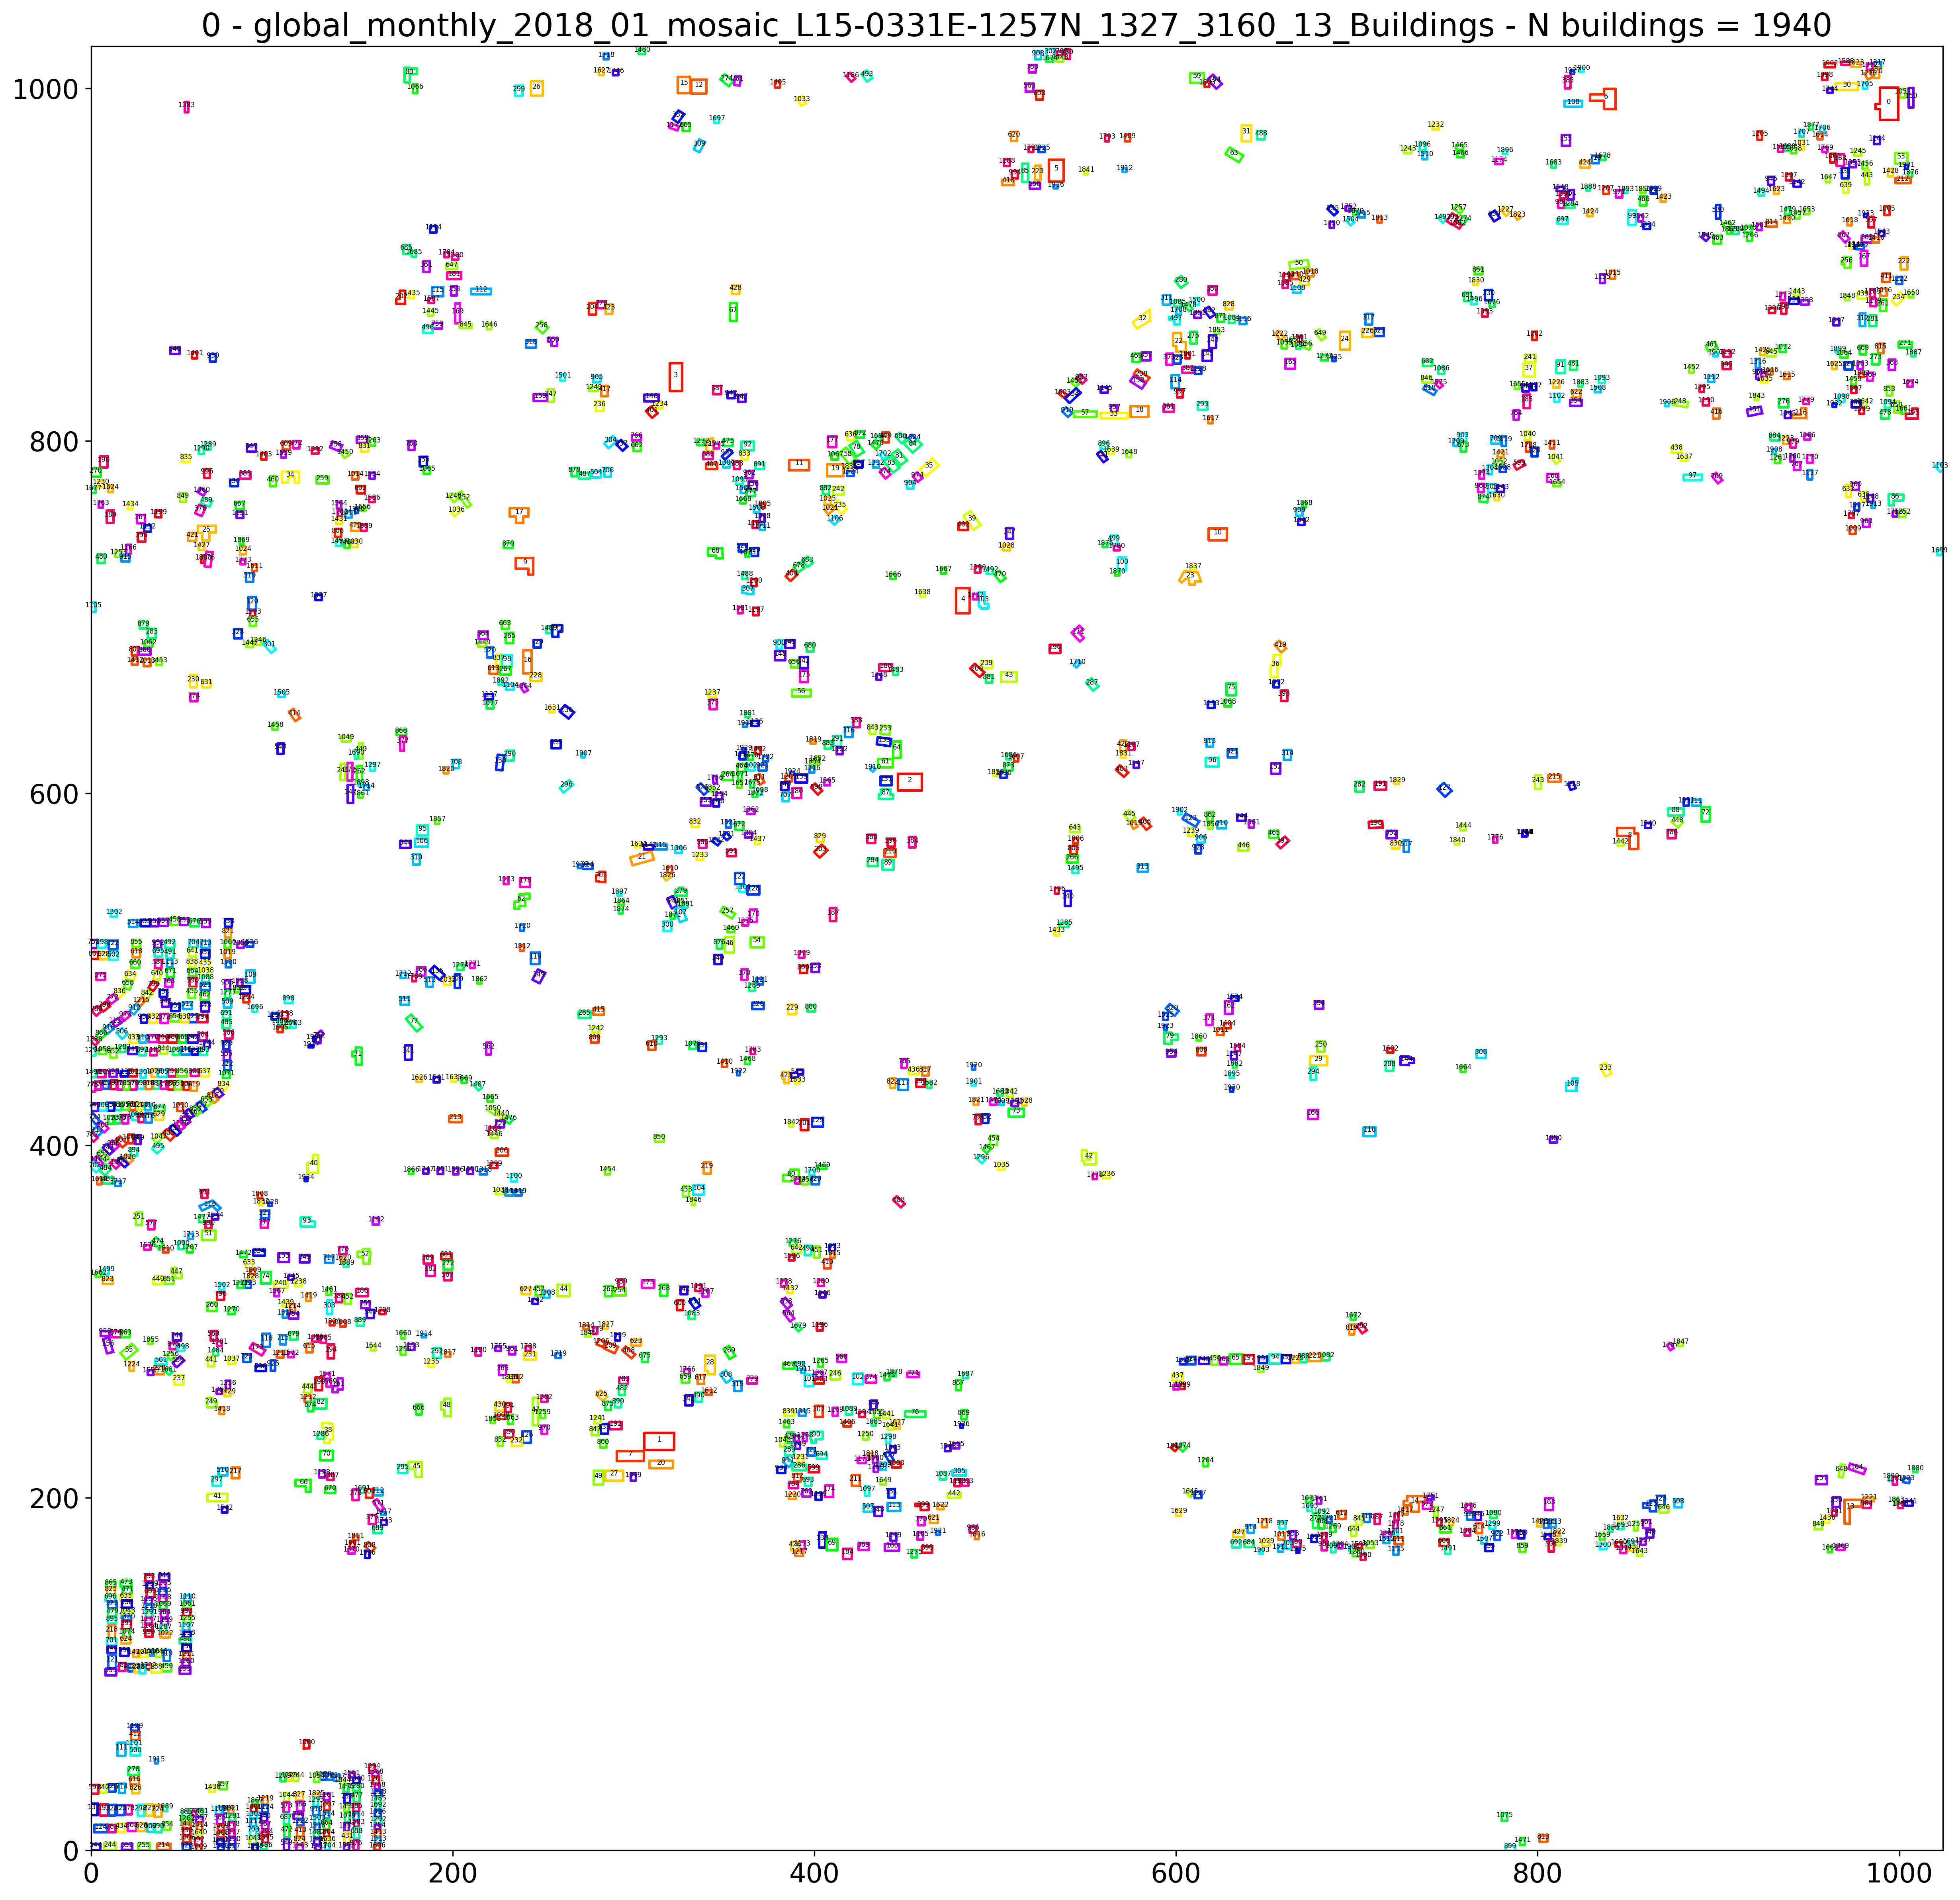

name_root: global_monthly_2020_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings


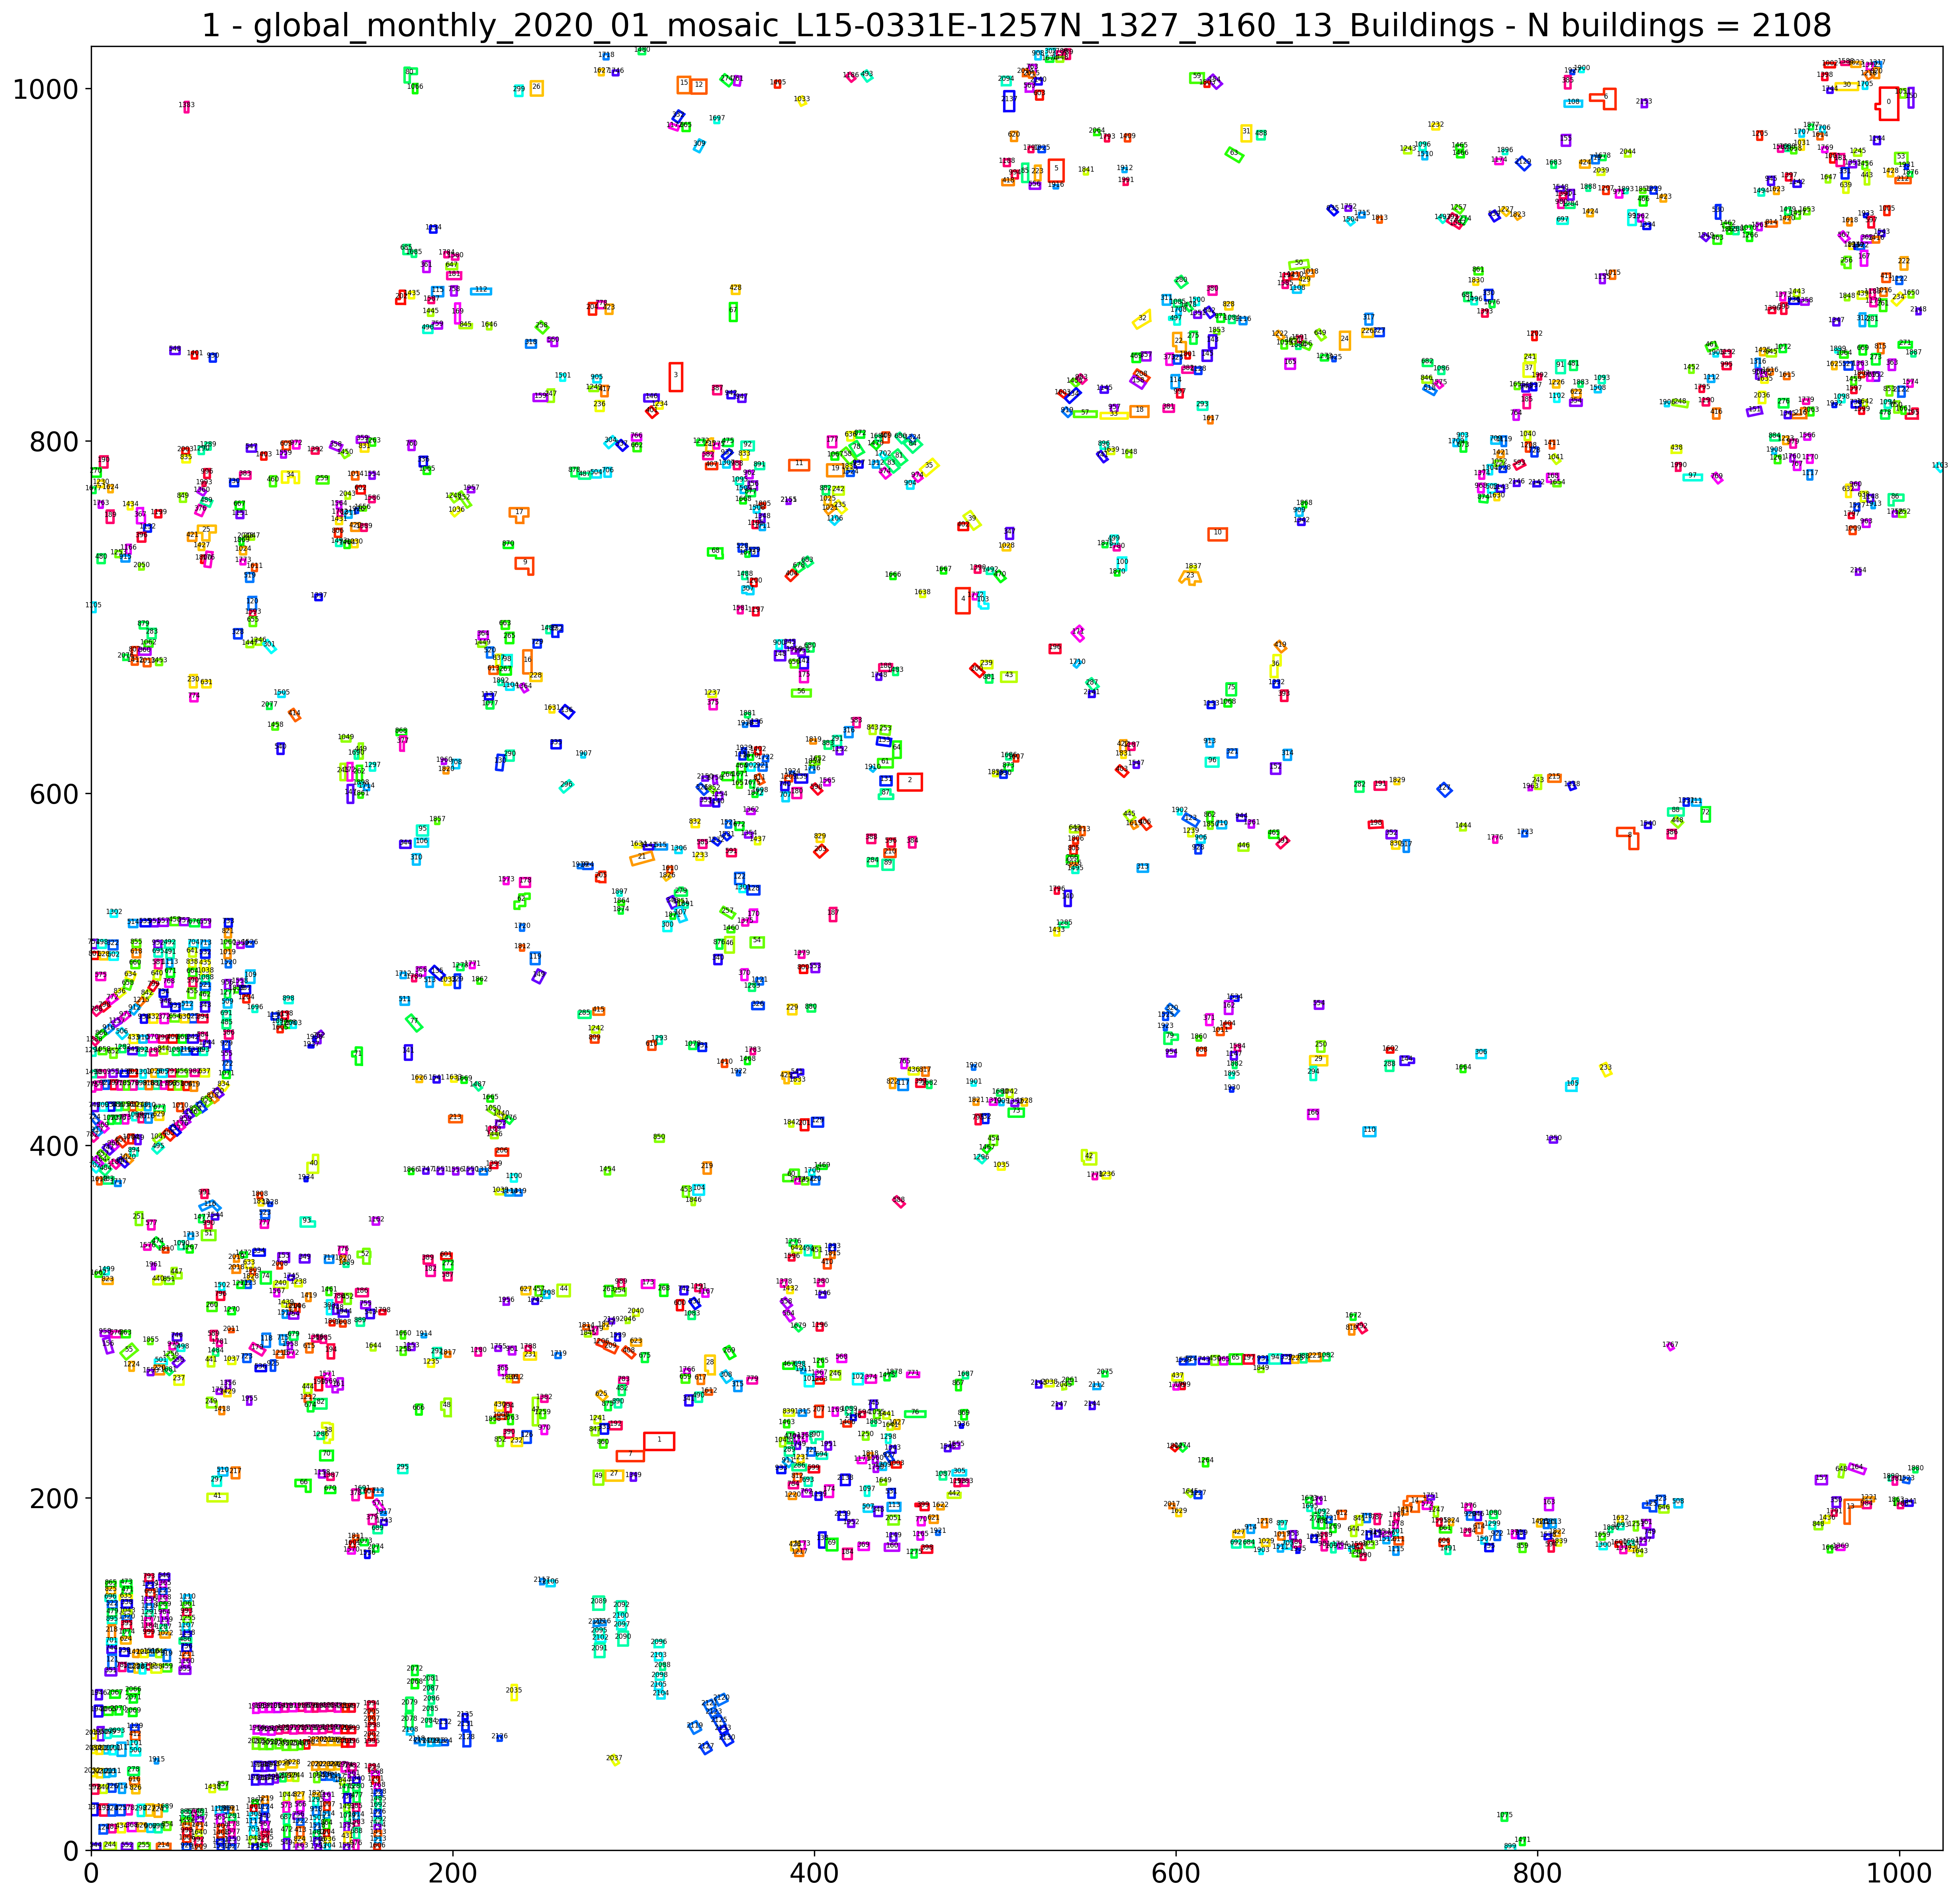

In [7]:
# make identifier plots

aoi = 'L15-0331E-1257N_1327_3160_13'
im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked')
json_dir = os.path.join(root_dir, 'train', aoi, 'labels_match/')

# colors
vmax = 200
cmap = plt.get_cmap('hsv')  # 'jet'
cNorm  = colors.Normalize(vmin=0, vmax=vmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
plot_only_first_and_last = True
label_font_size = 4
im_pix_size_x, im_pix_size_y = 1024, 1024
figsize=(20,20)

json_files = sorted([f
            for f in os.listdir(json_dir)
            if f.endswith('Buildings.geojson') and os.path.exists(os.path.join(json_dir, f))])
if plot_only_first_and_last:
    json_files = [json_files[0], json_files[-1]]

# convert json
for j, f in enumerate(json_files):
    # print(i, j, f)
    name_root = f.split('.')[0]
    json_path = os.path.join(json_dir, f)
    image_path = os.path.join(im_dir, name_root + '.tif').replace('_Buildings', '')
    print("name_root:", name_root)
    # print("json_path", json_path)
    # output_path = os.path.join(out_dir, f)
    # if os.path.exists(output_path):
    #    print("  path exists, skipping:", name_root)
    #    continue
    gdf_pix = sol.vector.polygon.geojson_to_px_gdf(json_path, image_path, geom_col='geometry', precision=None,
                  output_path=None, override_crs=False)
    fig, ax = plt.subplots(figsize=figsize)
    for _, row in gdf_pix.iterrows():
        geom = row['geometry']
        poly_id = row['Id']
        x, y = geom.exterior.xy
        cx, cy = np.array(geom.centroid.xy).astype(float)
        #print("centroid:", centroid)
        color_int = int(poly_id) % vmax
        colorVal = scalarMap.to_rgba(color_int)
        ax.plot(x, y, c=colorVal)
        # poly id
        ax.annotate(str(poly_id), xy=(cx, cy), ha='center', size=label_font_size)
        #text_object = plt.annotate(label, xy=(x_values[i], y_values[i]), ha='center')
        #ax.text(cx, cy, str(poly_id))
    ax.set_xlim(0, im_pix_size_x)
    ax.set_ylim(0, im_pix_size_y)
    title = str(j) + " - " + name_root + " - N buildings = " + str(len(gdf_pix))
    ax.set_title(title)

    plt.show()

In [8]:
# Make dataframe csvs for train/test

out_dir = os.path.join(root_dir, 'csvs/')
pops = ['train', 'test_public']
os.makedirs(out_dir, exist_ok=True)

for pop in pops: 
    d = os.path.join(root_dir, pop)
    outpath = os.path.join(out_dir, 'sn7_baseline_' + pop + '_df.csv')
    im_list, mask_list = [], []
    subdirs = sorted([f for f in os.listdir(d) if os.path.isdir(os.path.join(d, f))])
    for subdir in subdirs:
        
        if pop == 'train':
            im_files = [os.path.join(d, subdir, 'images_masked', f)
                    for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                    if f.endswith('.tif') and os.path.exists(os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif'))]
            mask_files = [os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif')
                      for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                      if f.endswith('.tif') and os.path.exists(os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif'))]
            im_list.extend(im_files)
            mask_list.extend(mask_files)
    
        elif pop == 'test_public':
            im_files = [os.path.join(d, subdir, 'images_masked', f)
                    for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                    if f.endswith('.tif')]
            im_list.extend(im_files)

    # save to dataframes
    # print("im_list:", im_list)
    # print("mask_list:", mask_list)
    if pop == 'train':
        df = pd.DataFrame({'image': im_list, 'label': mask_list})
        display(df.head())
    elif pop == 'test_public':
        df = pd.DataFrame({'image': im_list})
    df.to_csv(outpath, index=False)
    print(pop, "len df:", len(df))
    print("output csv:", outpath)

image  \
0  ../../train/L15-0331E-1257N_1327_3160_13/image...   
1  ../../train/L15-0331E-1257N_1327_3160_13/image...   
2  ../../train/L15-0331E-1257N_1327_3160_13/image...   
3  ../../train/L15-0331E-1257N_1327_3160_13/image...   
4  ../../train/L15-0331E-1257N_1327_3160_13/image...   

                                               label  
0  ../../train/L15-0331E-1257N_1327_3160_13/masks...  
1  ../../train/L15-0331E-1257N_1327_3160_13/masks...  
2  ../../train/L15-0331E-1257N_1327_3160_13/masks...  
3  ../../train/L15-0331E-1257N_1327_3160_13/masks...  
4  ../../train/L15-0331E-1257N_1327_3160_13/masks...

train len df: 1260
output csv: ../../csvs/sn7_baseline_train_df.csv
test_public len df: 466
output csv: ../../csvs/sn7_baseline_test_public_df.csv


--------
We are now ready to proceed with training and testing, see sn7_baseline.ipynb.